In [1]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
import pingouin as pg
import altair as alt

/home/sibu/.conda/envs/ddnv_env/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
dataset = ["yaz", "bakery","m5", "SID"]

best_results = pd.DataFrame()
cv_results = pd.DataFrame()

for d in dataset:
    best_results_temp = pd.read_csv("Results/best_results_"+d+".csv.zip")
    cv_results_temp = pd.read_csv("Results/cv_results_"+d+".csv.zip")
    best_results = pd.concat([best_results, best_results_temp],ignore_index=True)
    cv_results = pd.concat([cv_results, cv_results_temp],ignore_index=True)

## Load Results

## Best results

Note: In the Newsvendor case the Coefficient of Prescriptiveness is equal to the cost delta to SAA

In [3]:
best_results['feature combi'] = best_results['feature combi'].map(lambda x: re.sub(r"[]'[]", "", x))
best_results['feature combi'] = best_results['feature combi'].str.replace('_m5', '')
best_results['feature combi'] = best_results['feature combi'].str.replace('_bakery', '')
best_results['feature combi'] = best_results['feature combi'].str.replace('_yaz', '')

In [4]:
# rename datasets
best_results['dataset'] = best_results['dataset'].str.replace('yaz', 'Restaurant')
best_results['dataset'] = best_results['dataset'].str.replace('bakery', 'Bakery')
best_results['dataset'] = best_results['dataset'].str.replace('m5', 'M5')

In [5]:
best_results.drop(columns=["cu","co"], inplace=True)

In [6]:
# create column for rank
best_results["rank"] = best_results.groupby(["sl", "group", "dataset", "feature combi"])["coefficient of prescriptiveness"].rank("min", ascending=False)

In [7]:
# base case results
base_case = best_results[(best_results["sl"]==0.90) & (best_results["feature combi"]=="calendar, lag")]

# select the best model per group
best_model_per_group = best_results.loc[best_results.groupby(["sl", "group", "dataset", "feature combi"])['coefficient of prescriptiveness'].idxmax()]
best_model_per_group['model'] = pd.Categorical(best_model_per_group['model'], ["SAA", "KNNW", "DTW", "RFW", "KW", "LR", "DL"])

# select the best model per group from for base cas
best_model_per_group_BC = best_model_per_group[(best_model_per_group["sl"]==0.9) & (best_model_per_group["feature combi"]=="calendar, lag")]


## CV Results

In [8]:
cv_results['feature combi'] = cv_results['feature combi'].map(lambda x: re.sub(r"[]'[]", "", x))
cv_results['feature combi'] = cv_results['feature combi'].str.replace('_m5', '')
cv_results['feature combi'] = cv_results['feature combi'].str.replace('_bakery', '')
cv_results['feature combi'] = cv_results['feature combi'].str.replace('_yaz', '')

In [9]:
# rename datasets
cv_results['dataset'] = cv_results['dataset'].str.replace('yaz', 'Restaurant')
cv_results['dataset'] = cv_results['dataset'].str.replace('bakery', 'Bakery')
cv_results['dataset'] = cv_results['dataset'].str.replace('m5', 'M5')

In [10]:
# select columns
cv_results = cv_results[['mean_test_score', 'dataset', 'feature combi',
       'group', 'model', 'sl', 'params']]

In [11]:
# select best models per parameter gird
best_model_per_grid = cv_results.loc[cv_results.groupby(["model", "group", "dataset", "feature combi", "sl"])["mean_test_score"].idxmax()]

# create column for rank
best_model_per_grid["rank"] = best_model_per_grid.groupby(["group", "dataset", "feature combi", "sl"])["mean_test_score"].rank("min", ascending=False)

# select the best model per group from CV results
best_cv_model_per_group = best_model_per_grid.loc[best_model_per_grid.groupby(["group", "dataset", "feature combi", "sl"])['mean_test_score'].idxmax()]

# select columns
best_cv_model_per_group= best_cv_model_per_group.iloc[:,-10:]

# select the best model per group from CV results for base case
best_cv_model_per_group_bc = best_cv_model_per_group[(best_cv_model_per_group["feature combi"]=="calendar, lag") & (best_cv_model_per_group["sl"]==0.9)]

# get performance of the best cv model on the test data
performance_of_best_cv_model_on_test_data = best_results.merge(best_cv_model_per_group, on=["group", "dataset", "model", "sl", "feature combi"])

# Settings

In [12]:
datasets = best_results["dataset"].unique()

In [13]:
model_order = ["SAA", "KNNW", "DTW", "RFW", "KW", "LR", "DL"]
cop_model_order = ["KNNW", "DTW", "RFW", "KW", "LR", "DL"]

In [14]:
# color palette for different models
p = {"SAA": "#C62828", "RFW": "#0D47A1", "DTW": "#4FC3F7", "KNNW":"#CE93D8", "KW": "#FDD835", "LR": "#4CAF50", "DL": "#CC9966", "model selection": "xkcd:orange","Selection": "xkcd:orange"}
#p = {"SAA": sns.color_palette("Set2",8)[0], "RFW": sns.color_palette("Set2",8)[1], "DTW": sns.color_palette("Set2",8)[2], "KNNW":sns.color_palette("Set2",8)[3], "GKW": sns.color_palette("Set2",8)[4], "LR": sns.color_palette("Set2",8)[5], "DL": sns.color_palette("Set2",8)[6], "ES": sns.color_palette("Set2",8)[7]}

# standard column for all plots
c = "#1f77b4"

# Main plots

## Model comparison CoP for base case

<ipython-input-62-c5d42a178504>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_case.sort_values(["dataset"], inplace=True)


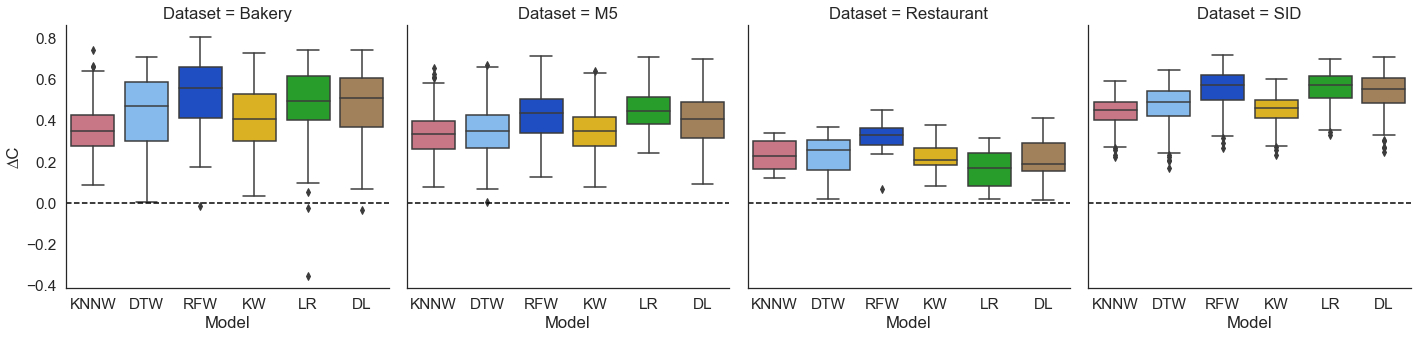

In [62]:
sns.set_theme(style="white", font_scale=1.4)

base_case.sort_values(["dataset"], inplace=True)
fig = sns.catplot(x="model", y="coefficient of prescriptiveness", data=base_case, kind="box", palette=p, col="dataset", order=cop_model_order)
for i in range(datasets.shape[0]):
    fig.axes[0][i].axhline(0, color="black", linestyle='--')
    
for ax in fig.axes.flatten():
    ax.set_ylabel("∆C")
    ax.set_xlabel("Model")
    
    d = ax.get_title().lstrip('dataset = ')
    ax.set_title(f"Dataset = {d}")

/home/sibu/.conda/envs/ddnv_env/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


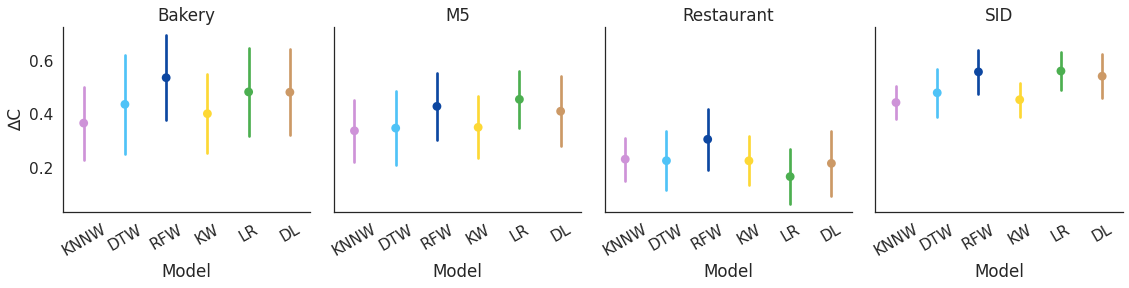

In [15]:
base_case.sort_values(["dataset"], inplace=True)
sns.set_theme(style="white", font_scale=1.4)

fig = sns.catplot(x="model", y="coefficient of prescriptiveness", data=base_case, kind="point", palette=p, col="dataset", order=cop_model_order, 
                  ci='sd', saturation=1, height=4, aspect=1)

#for i in range(datasets.shape[0]):
#    fig.axes[0][i].axhline(0, color="black", linestyle='--')
fig.set_xticklabels(rotation=30)

for ax in fig.axes.flatten():
    ax.set_ylabel("∆C")
    ax.set_xlabel("Model")
    d = ax.get_title().lstrip('dataset = ')
    ax.set_title(f"{d}")

In [16]:
fig.savefig("Plots/model comparison.png") 

## Rank plots

### Rank one overall

In [ ]:
df = best_model_per_group["model"].value_counts(normalize=True).mul(100).rename('percent').reset_index()
df["percent"] = df["percent"].round(1)
df.rename(columns={'index': 'model'}, inplace=True)

In [ ]:
sns.set_theme(style="white", font_scale=1.4)
fig = sns.catplot(data=df.loc[df.model.isin(cop_model_order),:], x="model",y='percent',kind='bar', color=c, order = cop_model_order)
for ax in fig.axes[0]:
    ax.set_ylabel("Percent")
    ax.set_xlabel("Model")

In [ ]:
fig.savefig("Plots/rank_one_overall.png")

### Rank one overall by dataset

In [ ]:
df = best_model_per_group.groupby(["dataset"])["model"].value_counts(normalize=True).mul(100).rename('percent').reset_index()
df["percent"] = df["percent"].round(1)
df.rename(columns={'level_1': 'model'}, inplace=True)

# set theme
sns.set_theme(style="white", font_scale=1.4)

fig = sns.catplot(data=df.loc[df.model.isin(cop_model_order),:], x="model",y='percent',col="dataset",kind='bar', color=c, order = cop_model_order)

for ax in fig.axes[0]:
    ax.set_ylabel("Percent")
    ax.set_xlabel("Model")
    d = ax.get_title().lstrip('dataset = ')
    ax.set_title(f"Dataset = {d}")


In [ ]:
fig.savefig("Plots/rank_one_overall_per_dataset.png")

### Rank one for base case

In [ ]:
df = best_model_per_group_BC["model"].value_counts(normalize=True).mul(100).rename('percent').reset_index()
df["percent"] = df["percent"].round(1)
df.rename(columns={'index': 'model'}, inplace=True)

In [ ]:
# set theme
sns.set_theme(style="white", font_scale=1.4)

fig = sns.catplot(data=df.loc[df.model.isin(cop_model_order),:], x="model",y='percent',kind='bar', color=c, order = cop_model_order)
for ax in fig.axes[0]:
    ax.set_ylabel("Percent")
    ax.set_xlabel("Model")

In [ ]:
fig.savefig("Plots/rank_one_base_case.png")

### Rank one by datasets for base case

In [65]:
df = best_model_per_group_BC.groupby(["dataset"])["model"].value_counts(normalize=True).mul(100).rename('percent').reset_index()
df["percent"] = df["percent"].round(1)
df.rename(columns={'level_1': 'model'}, inplace=True)

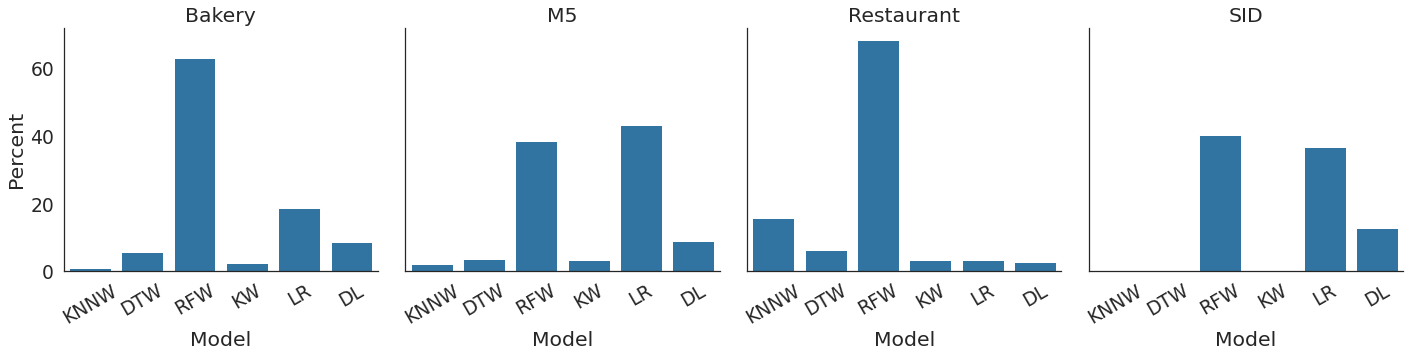

In [206]:
# set theme
sns.set_theme(style="white", font_scale=1.7)

fig = sns.catplot(data=df.loc[df.model.isin(cop_model_order),:], x="model",y='percent',col="dataset",kind='bar', color=c, order = cop_model_order, ci=None)

for ax in fig.axes[0]:
    ax.set_ylabel("Percent")
    ax.set_xlabel("Model")
    d = ax.get_title().lstrip('dataset = ')
    ax.set_title(f"{d}")
    
fig.set_xticklabels(rotation=30)

In [ ]:
fig.savefig("Plots/rank_one_per_dataset_base_case.png")

### Rank one by datasets for base case and differen variations

In [17]:
df1 = best_model_per_group_BC[(best_model_per_group.model!="SAA")]
df1["variation"] = "BC"
df2 = best_model_per_group[(best_model_per_group.sl==0.75) & (best_model_per_group["feature combi"]=="calendar, lag") & (best_model_per_group.model!="SAA")]
df2["variation"] = "Var1"
df3 = best_model_per_group[(best_model_per_group.sl==0.5) & (best_model_per_group["feature combi"]=="calendar, lag") & (best_model_per_group.model!="SAA")]
df3["variation"] = "Var2"
df4 = best_model_per_group[(best_model_per_group["feature combi"]=="calendar") & (best_model_per_group.sl==0.9) & (best_model_per_group.model!="SAA")]
df4["variation"] = "Var3"
df5 = best_model_per_group[(best_model_per_group["feature combi"]=="calendar, lag, special") & (best_model_per_group.sl==0.9) & (best_model_per_group.model!="SAA")]
df5["variation"] = "Var4"
df = pd.concat([df1,df2,df3,df4,df5])
df = df.groupby(["dataset", "variation"])["model"].value_counts(normalize=True).mul(100).rename('percent').reset_index()
df["percent"] = df["percent"]
df.rename(columns={'level_2': 'model'}, inplace=True)

#remove SAA
df= df.drop(index=df.loc[df.model=='SAA'].index)

# add zero values for SID Var4
df = pd.concat([df,pd.DataFrame([['SID','Var4','RFW',0]], columns=df.columns)])

/home/sibu/.conda/envs/ddnv_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/sibu/.conda/envs/ddnv_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/sibu/.conda/envs/ddnv_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


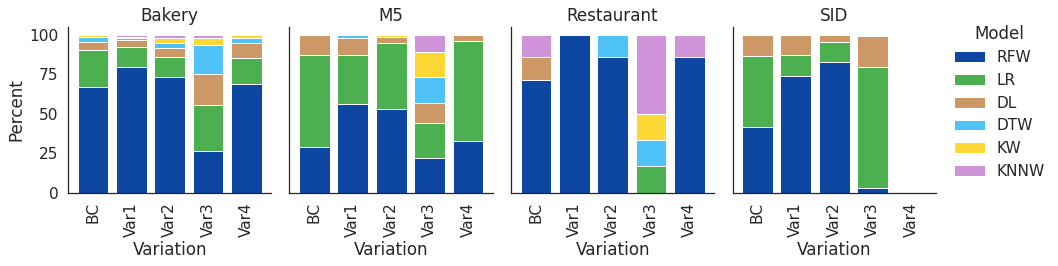

In [25]:
fig,ax = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=True)

for i,d in enumerate(df.dataset.unique()):
    
    df_d = df.loc[df.dataset==d,:].pivot(index='variation', columns='model', values='percent')
    df_d.columns = pd.CategoricalIndex(df_d.columns.values, ordered=True, categories=['RFW', 'LR', 'DL', 'DTW', 'KW', 'KNNW'])
    df_d = df_d.sort_index(axis=1)
    
    df_d.plot(ax=ax[i], kind='bar', stacked=True,width=0.8, color=p, figsize=(15,4), legend=False)
    
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    
    ax[i].set_title(f'{d}')
    
    ax[i].set_xlabel('Variation')
    
ax[0].set_ylabel('Percent')   
ax[3].legend(loc=3, bbox_to_anchor=(1.02,0), frameon=False, title='Model')

fig.tight_layout()

In [26]:
fig.savefig('Plots/breakdown_best_model.png')

chart.save('chart.json')## Line Plots 

### Performance variation of service levels

In [ ]:
##################
### USER INPUT ###
##################
best_results.sort_values(['dataset'], inplace=True)

# Select metric to use ("Average costs" or "Coefficient of Prescriptiveness")
metric = "coefficient of prescriptiveness"

# Select Models to plot. Possible are: "SAA", "GKW", "KNNW", "DTW", "RFW", "LR", "DL"
models = ["GKW", "KNNW", "DTW", "RFW", "LR", "DL"]

# Select feature combis to plot
features = [
            "calendar",
            "calendar, lag",
            "calendar, lag, special"
           ]

for f in features:
    print(f)
    fig = sns.catplot(x="sl", hue="model", y=metric, data=best_results[(best_results["feature combi"]==f) & (best_results.model.isin(models))], kind="point", col="dataset", 
                      ci='sd',
                      #ci=None, 
                      dodge=0.5,
                      sharey=False, 
                      palette=p, 
                      linestyles=' ', 
                      markers='D', scale=0.75
                     )
    
    fig._legend.set_title("Model")
    
    for ax in fig.axes.flatten():
        ax.set_ylabel("Average ∆C")
        ax.set_xlabel("Service level")

        d = ax.get_title().lstrip('dataset = ')
        ax.set_title(f"Dataset = {d}", fontsize=10)
        
    fig.figure.savefig("Plots/SL_variation_"+metric+" "+f+".png")  

### Performance variation of features

In [ ]:
##################
### USER INPUT ###
##################

# Select metric to use ("Average costs" or "Coefficient of Prescriptiveness")
metric = "coefficient of prescriptiveness"

# Select Models to plot. Possible are: "SAA", "GKW", "KNNW", "DTW", "RFW", "LR", "DL"
models = ["GKW", "KNNW", "DTW", "RFW", "LR", "DL"]

# Select SLs to plot. Possible are: 0.1, 0.25, 0.5, 0.75, 0.9
SLs = [0.1, 0.25, 0.5, 0.75, 0.9]

for SL in SLs:
    print(SL)
    fig = sns.catplot(x="feature combi", hue="model", y= metric, data=best_results[(best_results["sl"]==SL) & (best_results.model.isin(models))], kind="point", col="dataset", 
                      ci=None, sharey=False, sharex=False, order = ['calendar', ''],
                      palette=p, linestyles='--', markers='D', scale=0.75)
    
    fig._legend.set_title("Model")
    
    for ax in fig.axes.flatten():
        ax.set_ylabel("Average ∆C")
        ax.set_xlabel("Feature combination")

        d = ax.get_title().lstrip('dataset = ')
        ax.set_title(f"Dataset = {d}", fontsize=10)
    
    fig.figure.savefig("Plots/feature_variation_"+metric+" "+str(SL)+".png") 

## Model selection

In [27]:
##################
### USER INPUT ###
##################

# Select SL to plot. Possible are: 0.1, 0.25, 0.5, 0.75, 0.9
SL = 0.9

# Select feature combi to plot. 
features = "calendar, lag"

models = ["KW", "KNNW", "DTW", "RFW", "LR", "DL"]

model_sel = performance_of_best_cv_model_on_test_data.loc[(performance_of_best_cv_model_on_test_data.sl==SL)&(performance_of_best_cv_model_on_test_data['feature combi']==features),:]

best_results_sel = best_results.loc[(best_results.sl==SL)&(best_results['feature combi']==features),:]

best_results_sel.sort_values(['model', 'group'], inplace=True)
best_results_sel.reset_index(drop=True, inplace=True)

model_sel.sort_values(['group'], inplace=True)
model_sel = pd.concat([model_sel]*7, ignore_index=True)

best_results_sel['average_cost_model_selection'] = model_sel['coefficient of prescriptiveness']
best_results_sel['∆C(model selection)-∆C(k)'] = model_sel['coefficient of prescriptiveness'] - best_results_sel['coefficient of prescriptiveness']

/home/sibu/.conda/envs/ddnv_env/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/home/sibu/.conda/envs/ddnv_env/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sibu/.conda/envs/ddnv_env/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [28]:
#### Compute Wilcoxon signed-rank test statistics #####

wilcox = []
metric = 'coefficient of prescriptiveness'
model_sel = performance_of_best_cv_model_on_test_data.loc[(performance_of_best_cv_model_on_test_data.sl==SL)&(performance_of_best_cv_model_on_test_data['feature combi']==features),:]


# compute Wilcoxon signed-rank test per dataset
for d in best_results_sel.dataset.unique():
    
    model_sel_d = model_sel.loc[model_sel.dataset==d,:]
    model_sel.sort_values(by='group', inplace=True)
    
    for m in models:
        
        model_to_test = best_results_sel.loc[(best_results_sel.model==m)&(best_results_sel.dataset==d)]
        model_to_test.sort_values(by='group', inplace=True)
        
        try:
            w, p_v = pg.wilcoxon(model_sel_d[metric], model_to_test[metric], alternative='greater').loc['Wilcoxon',['W-val', 'p-val']]
        except:
            # if model selection and fixed model are equal, wilcoxon test will fail
            w, p_v = ('NA', 'NA')
            
        wilcox.append({'Dataset':d, 'Selected Model':m , 'test_statistic':w, 'p_value':p_v})
        
wilcox = pd.DataFrame(wilcox)
wilcox['p_value_star'] = [' ' if (x=='NA') else '***' if (x < 0.001) else '**' if (x < 0.01) else '*' if (x < 0.1) else ' ' for x in wilcox['p_value']]
wilcox['x_label'] = wilcox['Selected Model'] + wilcox['p_value_star']

/home/sibu/.conda/envs/ddnv_env/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


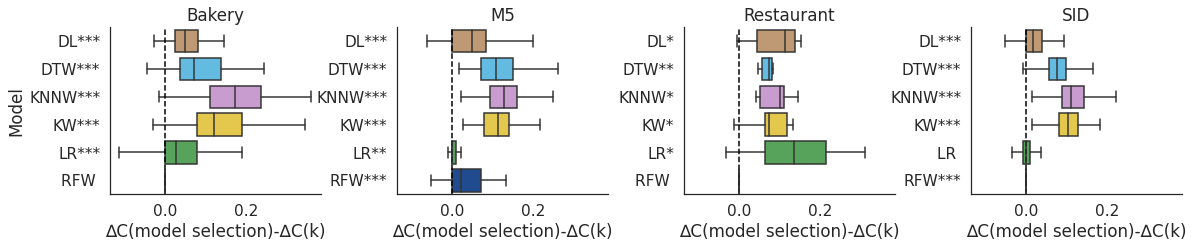

In [29]:
wilcox.sort_values(['Selected Model'], ascending=True, inplace=True)

sns.set_theme(style="white", font_scale=1.4)
g = sns.catplot(y="model", x="∆C(model selection)-∆C(k)", data=best_results_sel.loc[best_results_sel.model.isin(models),:], kind="box", hue="model", palette=p,
                col="dataset", col_order=['Bakery', 'M5', 'Restaurant', 'SID'], sharex=True, sharey=False, dodge=False, orient='h', showfliers=False, 
                height=3.75, aspect=1.1, legend=False)

g.axes[0,0].set_ylabel('Model')

for ax in g.axes.flatten():
    
    d = ax.get_title().lstrip('dataset = ')
    ax.set_title(f"{d}")
    
    ax.axvline(0, color="black", linestyle='--')
    
    m = [x.get_text() for x in ax.get_yticklabels()]
    ax.set_yticklabels(wilcox.loc[wilcox['Dataset']==d,'x_label'])

In [30]:
g.savefig(f"Plots/cost_delta_model_sel_{features}_SL_{SL}_per_dataset.png") 